In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np

In [26]:
merged_df = pd.read_csv('./zip_summary.csv')

# adding feature for analysis 
merged_df['complaints_per_10k'] = (merged_df['total_complaints'] / merged_df['total_population']) * 10000

merged_df.head()

,incident_zip,total_complaints,AHV Inspection Unit,APPLIANCE,Abandoned Bike,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,...,NAME,total_population,median_income,poverty_universe,below_poverty,white_alone,black_alone,hispanic,poverty_rate,complaints_per_10k
0,10000,24,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,632,0,0,2,1,1,0,0,4,...,ZCTA5 10001,25026.0,96787.0,24140.0,2798.0,15880.0,1619.0,3925.0,0.115907,252.537361
2,10002,856,0,4,2,5,1,0,8,1,...,ZCTA5 10002,74363.0,35607.0,73597.0,20257.0,23574.0,6645.0,19155.0,0.275242,115.111010
3,10003,686,0,2,1,0,4,0,0,2,...,ZCTA5 10003,54671.0,129981.0,45570.0,4040.0,39951.0,2759.0,4732.0,0.088655,125.477858
4,10004,265,0,0,0,1,0,0,0,0,...,ZCTA5 10004,3310.0,204949.0,3310.0,93.0,2259.0,160.0,193.0,0.028097,800.604230


In [27]:
[col for col in merged_df.columns if 'borough' in col.lower()]

['borough']

We know that underreporting may be more common when poverty rate is high based on our initial data exploration. We want to explore an ML model that detects hidden underreporting cases.

We will be taking an unsupervised learning approach to find zip codes that have strange patterns compared to the norm. 

We will be using an isolation forest model to find rare cases in high dimensional data, which is perfect for underreporting. 

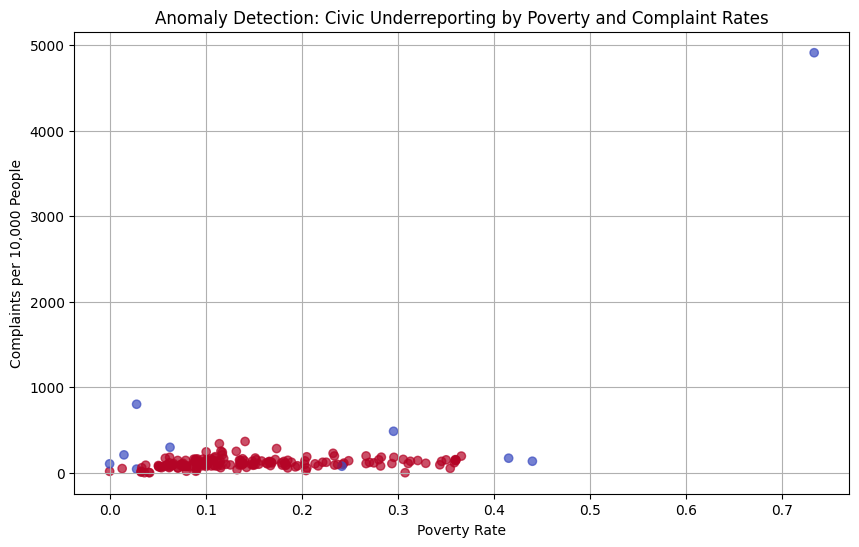

In [28]:
# we will examine how much people report, how economically stressed 
# the area is, and how many people are affected. 

features = ['complaints_per_10k', 'poverty_rate', 'median_income', 'total_population']
X = merged_df[features].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

merged_ml = merged_df.loc[X.index].copy()

# Predict anomaly labels (-1 = anomaly, 1 = normal) and scores
merged_ml['anomaly'] = iso_forest.predict(X_scaled)  
merged_ml['anomaly_score'] = iso_forest.decision_function(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(merged_ml['poverty_rate'], merged_ml['complaints_per_10k'], 
            c=merged_ml['anomaly'], cmap='coolwarm', alpha=0.7)
plt.xlabel('Poverty Rate')
plt.ylabel('Complaints per 10,000 People')
plt.title('Anomaly Detection: Civic Underreporting by Poverty and Complaint Rates')
plt.grid(True)
plt.show()

In [29]:
print(merged_ml[['incident_zip', 'anomaly', 'anomaly_score']].head())

   incident_zip  anomaly  anomaly_score
1         10001        1       0.110352
2         10002        1       0.103166
3         10003        1       0.119661
4         10004       -1      -0.142937
5         10005        1       0.068830


Plot 1: 

When an anomaly = 1, the model thinks that the zip code does not follow a general pattern, in this case, the zip code is not an underreporter. The higher the anomaly score, the more normal the zip code is. When an anomaly = -1, the model think that the zip code is an anomaly, meaning that it is likely that there is underreporting. The lower the anomaly score, the more anbormal the zip code is. 

The zip code 10004 has anomaly = -1 and an anomaly score of -0.142937. This zip code is flagged as an anomaly as it likely has suspiciously low complaints compared to its poverty rate, income, and population.

In [34]:
# Fix invalid median_income values
merged_ml['median_income'] = merged_ml['median_income'].replace(-666666666.0, np.nan)

# Select only anomalies (potential underreporters)
underreporting_zips = merged_ml[merged_ml['anomaly'] == -1]

# Sort by anomaly_score ascending (most negative first)
top_underreporters = underreporting_zips.sort_values('anomaly_score').head(10)

print(top_underreporters[['incident_zip', 'borough', 'complaints_per_10k', 'poverty_rate', 'median_income', 'anomaly_score']])

     incident_zip    borough  complaints_per_10k  poverty_rate  median_income  \
201         11430     QUEENS         4909.090909      0.733645            NaN   
68          10279  MANHATTAN          104.166667      0.000000            NaN   
4           10004  MANHATTAN          800.604230      0.028097       204949.0   
156         11239   BROOKLYN          484.725686      0.295652        29571.0   
107         10474      BRONX          170.135590      0.415486        28419.0   
87          10454      BRONX          134.631153      0.440202        23337.0   
7           10007  MANHATTAN          208.828972      0.014939       250001.0   
71          10282  MANHATTAN           42.720999      0.028097       250001.0   
129         11211   BROOKLYN           76.319086      0.241859        90871.0   
6           10006  MANHATTAN          297.546012      0.062883       185268.0   

     anomaly_score  
201      -0.337773  
68       -0.241985  
4        -0.142937  
156      -0.074403  
107

Using the Isolation Forest model, we identified the top 10 zip codes with unusually low complaint rates given their demographics. These neighborhoods exhibited significantly lower civic reporting activity despite high poverty rates and large populations, suggesting potential underreporting issues.

Based on the outcomes using an isloation forest model, Zip codes with bad income data were flagged likely because of missing Census data. Zip codes with very low complaints per 10k people even when poverty rates are moderate/high were flagged as well. Even wealthy zip codes with low poverty but low complaints. 

Additional Quality Check: 

During the analysis, we observed invalid median income values (-666,666,666) for a small number of zip codes. These were treated as missing values, as they likely arose from unmatched records during dataset merging.

In [35]:
# Only show anomalies where median income is not missing
underreporting_zips = merged_ml[(merged_ml['anomaly'] == -1) & (merged_ml['median_income'].notnull())]

top_underreporters = underreporting_zips.sort_values('anomaly_score').head(10)

print(top_underreporters[['incident_zip', 'borough', 'complaints_per_10k', 'poverty_rate', 'median_income', 'anomaly_score']])

     incident_zip    borough  complaints_per_10k  poverty_rate  median_income  \
4           10004  MANHATTAN          800.604230      0.028097       204949.0   
156         11239   BROOKLYN          484.725686      0.295652        29571.0   
107         10474      BRONX          170.135590      0.415486        28419.0   
87          10454      BRONX          134.631153      0.440202        23337.0   
7           10007  MANHATTAN          208.828972      0.014939       250001.0   
71          10282  MANHATTAN           42.720999      0.028097       250001.0   
129         11211   BROOKLYN           76.319086      0.241859        90871.0   
6           10006  MANHATTAN          297.546012      0.062883       185268.0   

     anomaly_score  
4        -0.142937  
156      -0.074403  
107      -0.054627  
87       -0.043674  
7        -0.029444  
71       -0.024345  
129      -0.023634  
6        -0.000669  


After showing anamolies with non missing data: 

Bronx zips (10474, 10454) have high poverty but low complaints, which likely suggests civic underreporting. Brooklyn zip (11211) has moderate poverty but low complaints, suggesting possible underreporting, and Manhattan zips (10282) have low poverty and very low complaints, which could be less critical, but still an interesting anomaly. 

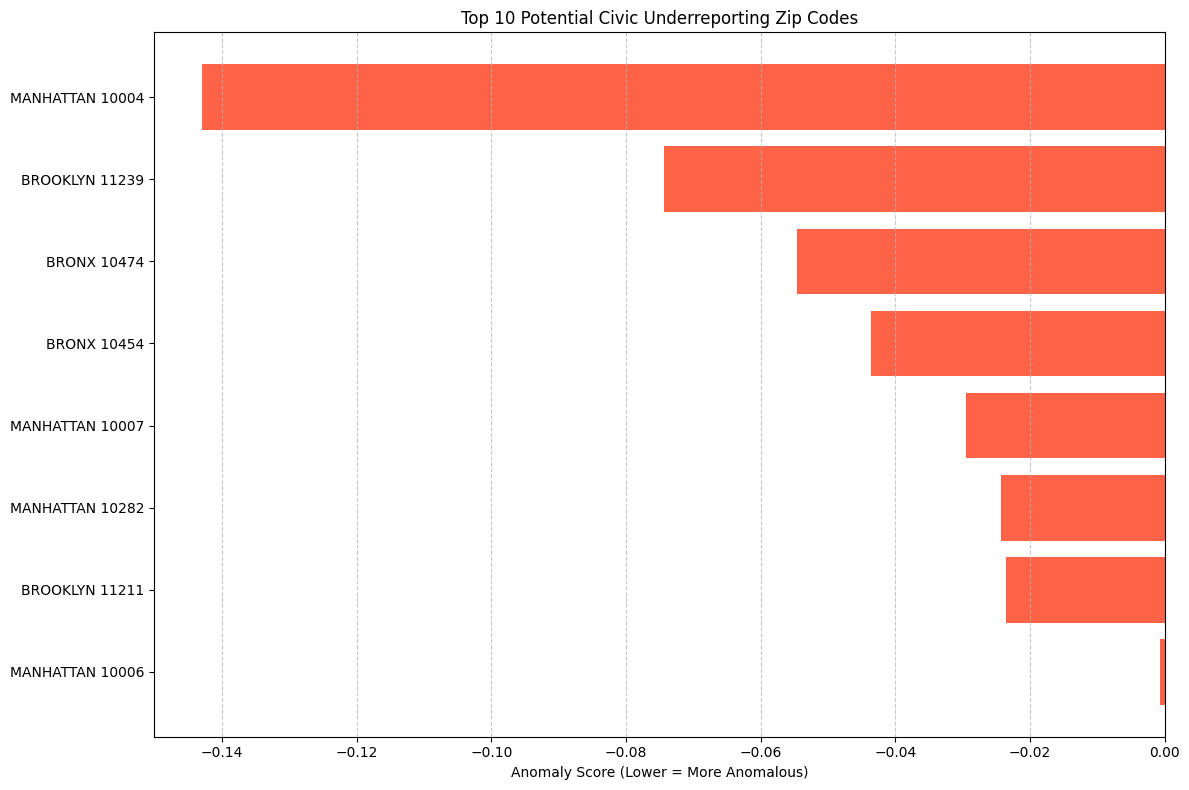

In [37]:
# viewing top civic underreporting
top_underreporters['label'] = top_underreporters['borough'] + " " + top_underreporters['incident_zip'].astype(str)

# Sort so that the most abnormal is at the top of the bar chart
top_underreporters = top_underreporters.sort_values('anomaly_score')


plt.figure(figsize=(12,8))
plt.barh(top_underreporters['label'], top_underreporters['anomaly_score'], color='tomato')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.title('Top 10 Potential Civic Underreporting Zip Codes')
plt.gca().invert_yaxis()  # Highest anomaly (most negative score) at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Note: Manhattan 10004 is located in the Financial District, so it is mostly non residential. On the contrary, Brooklyn 11239 is the Spring Creek Neighborhood, with a median household income of $26,275, which supports claims for underreporting in lower income communities. 

## Feature Engineering

In [8]:
def load_datasets(
        zip_path: str = "./zip_summary.csv",
        merged_path: str = "./merged_nyc_311_census_data.csv"
):
    zs = pd.read_csv(zip_path)
    df = pd.read_csv(merged_path, parse_dates = ["created_date"])
    return zs, df

def clean_zip(z):
    """
    Turn 10000.0/10000 into "10000",
    drop anything that isn't a 5-digit.
    """
    try:
        zi = int(float(z))
        return str(zi)
    except Exception:
        return None

zs, df = load_datasets()
print(f"ZIP summary rows: {len(zs)}, merged data rows: {len(df)}")

# Lag feature and complaint rate
# Ensure ZIP codes are strings
zs['incident_zip'] = zs['incident_zip'].apply(clean_zip)
df['incident_zip'] = df['incident_zip'].apply(clean_zip)

# drop all truly invalid/missing zips
zs = zs.dropna(subset=['incident_zip'])
df = df.dropna(subset=['incident_zip'])

# Aggregate monthly complaint counts
df["month"] = df["created_date"].dt.to_period("M").dt.to_timestamp()
monthly = df.groupby(["incident_zip", "month"]).size().reset_index(name="complaint_count")

# Merge ZIP-level population
zs["total_population"] = pd.to_numeric(zs["total_population"], errors="coerce")
monthly = monthly.merge(
    zs[["incident_zip", "total_population"]],
    on="incident_zip",
    how="left"
)

# Compute complaint rate per 1k
monthly["complaint_rate_per_1000"] = monthly["complaint_count"] / (monthly["total_population"] / 1000)

# Extract calendar month for seasonality
monthly["month_num"] = monthly["month"].dt.month

monthly.head()

ZIP summary rows: 216, merged data rows: 100000


,incident_zip,month,complaint_count,total_population,complaint_rate_per_1000,month_num
0,10000,2025-04-01,24,NaN,NaN,4
1,10001,2025-04-01,632,25026.0,25.253736,4
2,10002,2025-04-01,856,74363.0,11.511101,4
3,10003,2025-04-01,686,54671.0,12.547786,4
4,10004,2025-04-01,265,3310.0,80.060423,4


In [23]:
# WEEKLY FEATURE ENGINEERING (change_rate, surge_factor, diversity, resolution)

import pandas as pd
import numpy as np

# 1) Load & clean
zs = pd.read_csv('./zip_summary.csv') 
df = pd.read_csv(
    './merged_nyc_311_census_data.csv',
    parse_dates=['created_date', 'closed_date'],
)

# Helper to turn floats or ints into 5-digit strings, else drop
def clean_zip(z):
    try:
        zi = int(float(z))
        return f"{zi:05d}"
    except:
        return None

for _df in (zs, df):
    _df['incident_zip'] = _df['incident_zip'].apply(clean_zip)
df = df.dropna(subset=['incident_zip'])
zs = zs.dropna(subset=['incident_zip', 'total_population'])
zs['total_population'] = pd.to_numeric(zs['total_population'], errors='coerce')

# 2) Compute resolution in hours
df['resolution_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600

# 3) Bucket into ISO-week
df['week'] = df['created_date'].dt.to_period('W').dt.start_time

# 4) Entropy helper
def shannon_entropy(series):
    counts = series.value_counts()
    p = counts / counts.sum()
    return float(-(p * np.log2(p)).sum())

def p90_safe(x):
    arr = x.dropna().values
    return np.percentile(arr, 90) if arr.size else np.nan

weekly = df.groupby(['incident_zip','week']).agg(
    complaint_count        = ('unique_key',       'count'),
    complaint_diversity    = ('complaint_type',   shannon_entropy),
    avg_resolution_hours   = ('resolution_hours', 'mean'),
    p90_resolution_hours   = ('resolution_hours', p90_safe)
).reset_index()
# 6) Merge in population and compute rate per 1k
weekly = weekly.merge(
    zs[['incident_zip','total_population']],
    on='incident_zip',
    how='inner'
)
weekly['complaint_rate_per_1000'] = (
    weekly['complaint_count'] / (weekly['total_population'] / 1_000)
)

# 7) Change rate (w/w) and 6-week surge factor
weekly = weekly.sort_values(['incident_zip','week'])
grp = weekly.groupby('incident_zip')['complaint_rate_per_1000']

weekly['change_rate']  = grp.diff(1) / grp.shift(1)
weekly['surge_factor'] = (
    weekly['complaint_rate_per_1000']
    / grp.rolling(6, min_periods=1).mean().reset_index(level=0, drop=True)
)

# 8) Quick descriptive stats
print("=== Descriptive Statistics ===")
print( weekly[['change_rate','surge_factor','complaint_diversity',
               'avg_resolution_hours','p90_resolution_hours']].describe() )

weekly


=== Descriptive Statistics ===
       change_rate  surge_factor  complaint_diversity  avg_resolution_hours  \
count   358.000000    544.000000           569.000000            561.000000   
mean      1.098119      1.049572             3.734974             14.183643   
std       2.034694      0.409766             1.118420             12.418148   
min      -0.924695      0.193640            -0.000000            -34.862418   
25%      -0.693308      0.647808             3.418531              4.664257   
50%       0.284722      1.000000             3.998415             13.407565   
75%       2.604544      1.508494             4.480175             19.990912   
max      10.500000      1.840000             5.211319            119.566667   

       p90_resolution_hours  
count            561.000000  
mean              41.657958  
std               31.058536  
min                0.000000  
25%               14.727139  
50%               43.222667  
75%               62.392500  
max              

/var/folders/rx/2fx_mz354lsdc_dhdg30skn80000gn/T/ipykernel_11660/518963841.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resolution_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600
/var/folders/rx/2fx_mz354lsdc_dhdg30skn80000gn/T/ipykernel_11660/518963841.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = df['created_date'].dt.to_period('W').dt.start_time


,incident_zip,week,complaint_count,complaint_diversity,avg_resolution_hours,p90_resolution_hours,total_population,complaint_rate_per_1000,change_rate,surge_factor
0,10001,2025-04-07,103,3.873683,25.774182,109.100000,25026.0,4.115720,NaN,1.000000
1,10001,2025-04-14,391,4.366408,15.845947,51.616778,25026.0,15.623751,2.796117,1.582996
2,10001,2025-04-21,138,4.334333,1.663416,2.771556,25026.0,5.514265,-0.647059,0.655063
3,10002,2025-04-07,160,3.600470,11.188167,49.133139,74363.0,2.151608,NaN,1.000000
4,10002,2025-04-14,520,4.612953,8.247371,24.431556,74363.0,6.992725,2.250000,1.529412
...,...,...,...,...,...,...,...,...,...,...
564,11694,2025-04-21,39,3.530015,3.149907,4.241667,21258.0,1.834603,-0.743421,0.471774
565,11697,2025-04-21,1,-0.000000,0.000000,0.000000,3527.0,0.283527,NaN,1.000000
566,11801,2025-04-14,1,-0.000000,72.637222,72.637222,40179.0,0.024889,NaN,1.000000
567,19013,2025-04-14,1,-0.000000,NaN,NaN,35113.0,0.028479,NaN,1.000000


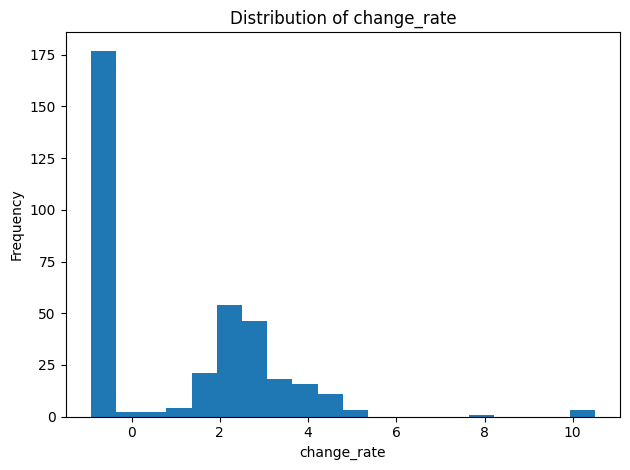

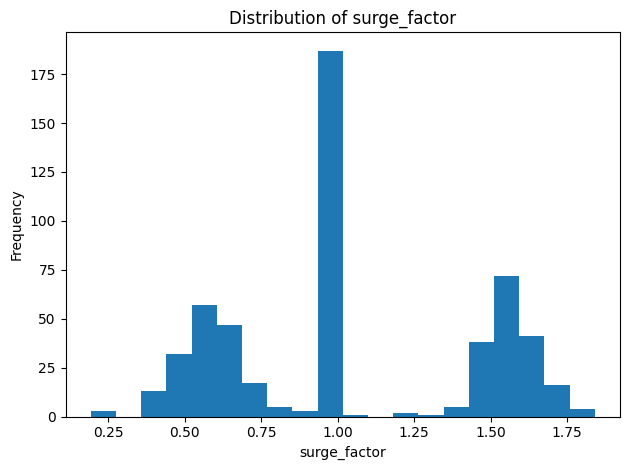

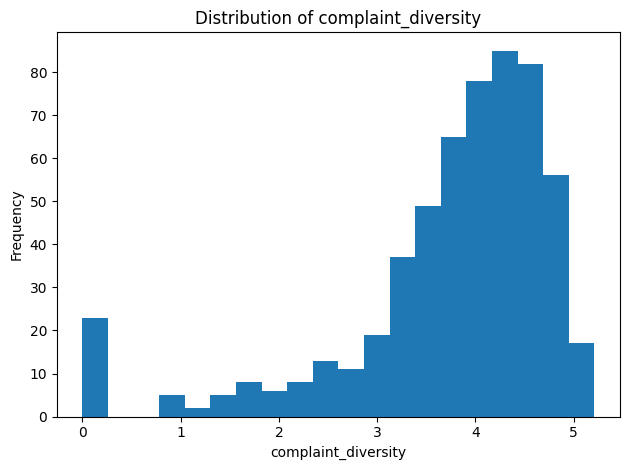

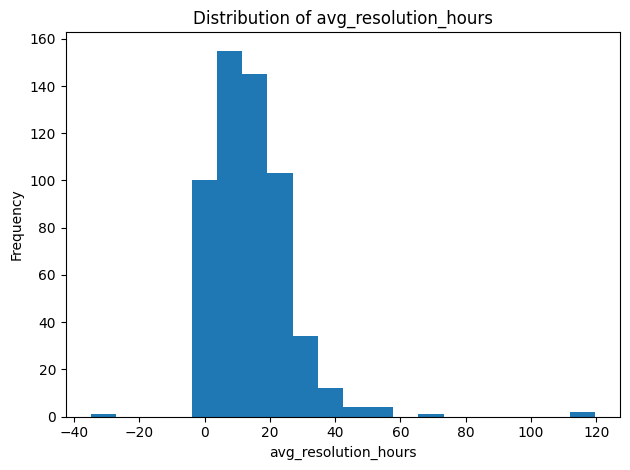

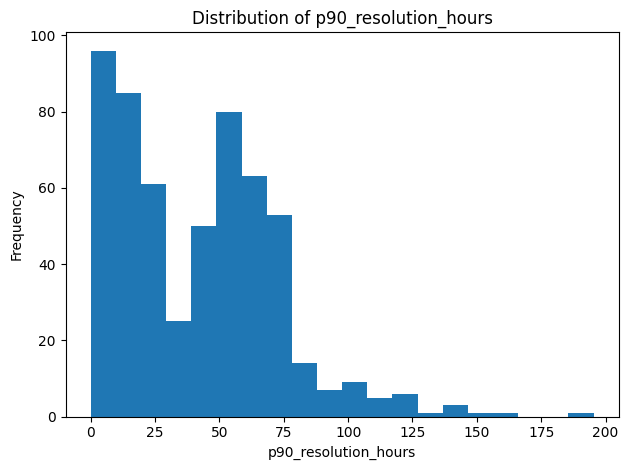

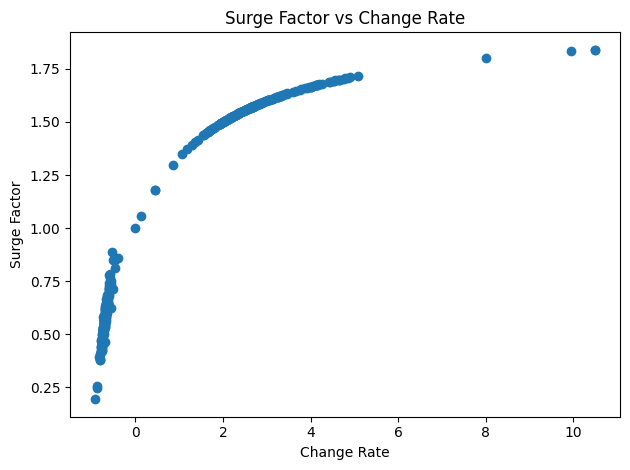

In [ ]:
# Plot 1: Histograms
for var in ['change_rate','surge_factor','complaint_diversity','p90_resolution_hours']:
    plt.figure()
    plt.hist(weekly[var].dropna(), bins=20)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.tight_layout()

# Plot 2: Scatter surge vs change
plt.figure()
plt.scatter(weekly['change_rate'], weekly['surge_factor'])
plt.title('Surge Factor vs Change Rate')
plt.xlabel('Change Rate')
plt.ylabel('Surge Factor')
plt.tight_layout()

plt.show()

Zip codes with spiked change rates are worth investigating to see the cause of the additional reporting. The surge factor has two clusters: one at 0.5 - 0.8 and another at 1.3-1.7. Since surge factor normalizes for how busy a zip code is, a small numerical jump can appear bigger in a quieter zip code and vice versa. As for complaint diversity, attention should be prioritized in locations with 0, since it means calls are about the same issue. Surge factor vs change rate returns a curve with logarithmic behavior (concave down). As the change rate grows, surge factor grows but at a slower rate (with a small outlier). 

In [32]:
# normalize, z scores

acs_cols = [
    "total_population", "median_income",
    "poverty_universe", "below_poverty",
    "white_alone", "black_alone", "hispanic",
    "poverty_rate"
]

# Coerce and compute z-scores
for c in acs_cols:
    zs[c] = pd.to_numeric(zs[c], errors="coerce")
    zs[f"{c}_zscore"] = (zs[c] - zs[c].mean()) / zs[c].std()

# Display sample of normalized features
zs[[f"{c}_zscore" for c in acs_cols]].head()


,total_population_zscore,median_income_zscore,poverty_universe_zscore,below_poverty_zscore,white_alone_zscore,black_alone_zscore,hispanic_zscore,poverty_rate_zscore
1,-0.607992,0.312075,-0.621190,-0.580834,-0.107543,-0.553973,-0.568634,-0.353001
2,1.128839,0.311754,1.140008,1.767278,0.378767,-0.222604,0.491785,1.206337
3,0.435613,0.312250,0.141947,-0.413794,1.413900,-0.478812,-0.512445,-0.619708
4,-1.372470,0.312643,-1.362961,-0.944638,-0.968479,-0.650166,-0.828482,-1.212363
5,-1.183991,0.312537,-1.172301,-0.869322,-0.711418,-0.649243,-0.805087,-0.749727


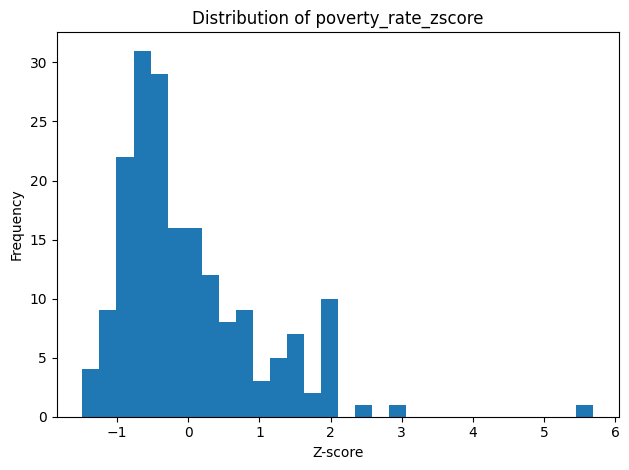

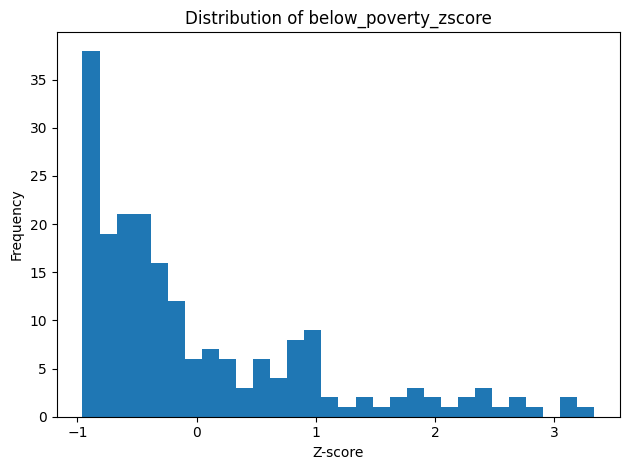

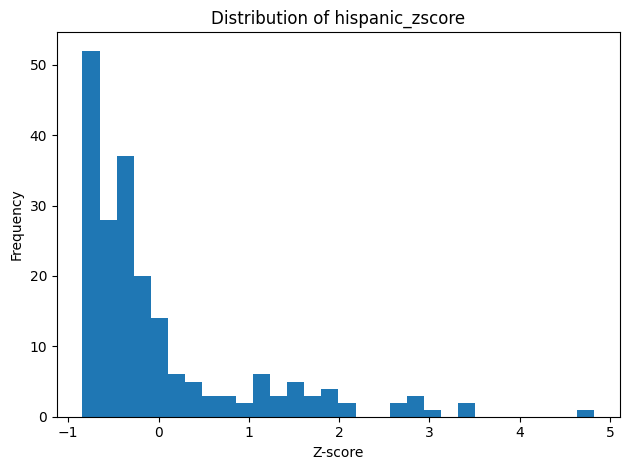

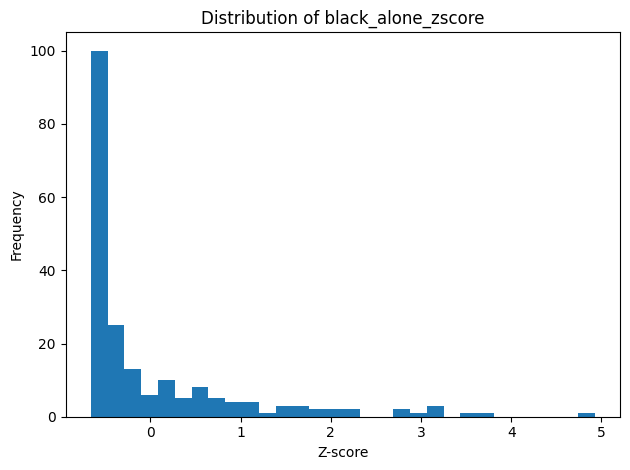

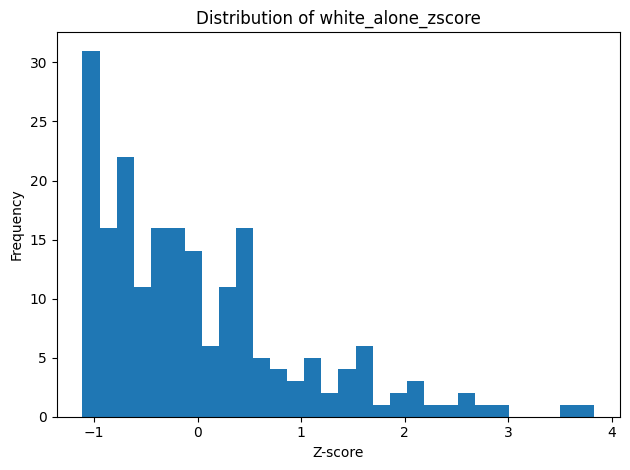

In [37]:

zscore_cols = [f"{c}_zscore" for c in acs_cols]

keep_cols = [
    "poverty_rate_zscore",
    "below_poverty_zscore",
    "hispanic_zscore",
    "black_alone_zscore",
    "white_alone_zscore"
]
# 1) One histogram per feature
for col in keep_cols:
    plt.figure()
    plt.hist(zs[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Z-score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

The poverty_rate_zscore one shows a right skewed graph, a prime indicator for anti-poverty outreach. The below poverty graph has a long right tail, which suggests a discrepancy in the amount of people living below poverty and the amount of hardship people face. Hispanic and black population outliers suggests the existence of zip codes where these populations are the majority. An intervention to alleviate this is by addressing language/accessibility barriers to use 311. Education, and the knowledge of 311 calls can serve multiple languages are examples. 

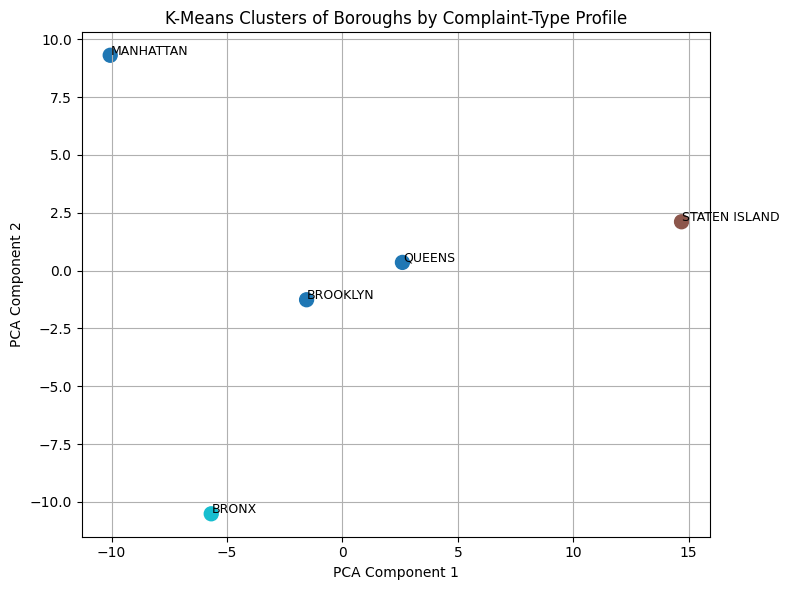

Borough → Cluster assignment:
borough
BRONX            2
BROOKLYN         0
MANHATTAN        0
QUEENS           0
STATEN ISLAND    1
Name: cluster, dtype: int32
Top 3 positive contributors to PC1:
  Overgrown Tree/Branches        0.117
  Damaged Tree                   0.116
  Street Sign - Dangling         0.116

Top 3 negative contributors to PC1:
  Smoking or Vaping              -0.116
  Water Quality                  -0.111
  Noise - Street/Sidewalk        -0.110

Top 3 positive contributors to PC2:
  Food Poisoning                 0.149
  Unsanitary Pigeon Condition    0.146
  Dumpster Complaint             0.146

Top 3 negative contributors to PC2:
  Industrial Waste               -0.142
  Public Toilet                  -0.129
  Noise - Residential            -0.126


In [51]:
# %% Unsupervised Clustering of Borough Complaint Patterns with K-Means

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv('./merged_nyc_311_census_data.csv', parse_dates=['created_date'])

# 1a) REMOVE the “Unspecified” borough
df = df[df['borough'].str.upper() != 'UNSPECIFIED'].copy()

# 2) Pivot to get counts of each complaint type per borough
complaints = (
    df
    .groupby(['borough', 'complaint_type'])
    .size()
    .unstack(fill_value=0)
)

# 3) Normalize by total complaints in each borough so we cluster on proportions
complaints_norm = complaints.div(complaints.sum(axis=1), axis=0)

# 4) Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X = scaler.fit_transform(complaints_norm)

# 5) Run K-Means (here: 3 clusters; feel free to adjust)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
complaints_norm['cluster'] = labels

# 6) Reduce to 2D for visualization via PCA
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X)

# 7) Scatter plot of boroughs in PCA space, colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=labels, cmap='tab10', s=100)
for i, borough in enumerate(complaints_norm.index):
    plt.text(pcs[i, 0] + 0.02, pcs[i, 1] + 0.02, borough, fontsize=9)
plt.title("K-Means Clusters of Boroughs by Complaint-Type Profile")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8) Print out which cluster each borough belongs to
print("Borough → Cluster assignment:")
print(complaints_norm['cluster'])

# 5) Zip each complaint_type to its PC1 & PC2 loading
features = complaints_norm.columns.tolist()
pc1_loadings = list(zip(features, pca.components_[0]))
pc2_loadings = list(zip(features, pca.components_[1]))

# 6) Sort and grab top/bottom 5 for each
top3_pc1    = sorted(pc1_loadings, key=lambda x: x[1], reverse=True)[:3]
bottom3_pc1 = sorted(pc1_loadings, key=lambda x: x[1])[:3]
top3_pc2    = sorted(pc2_loadings, key=lambda x: x[1], reverse=True)[:3]
bottom3_pc2 = sorted(pc2_loadings, key=lambda x: x[1])[:3]

# 7) Print results
print("Top 3 positive contributors to PC1:")
for feat, val in top3_pc1:
    print(f"  {feat:30s} {val:.3f}")

print("\nTop 3 negative contributors to PC1:")
for feat, val in bottom3_pc1:
    print(f"  {feat:30s} {val:.3f}")

print("\nTop 3 positive contributors to PC2:")
for feat, val in top3_pc2:
    print(f"  {feat:30s} {val:.3f}")

print("\nTop 3 negative contributors to PC2:")
for feat, val in bottom3_pc2:
    print(f"  {feat:30s} {val:.3f}")


3 clusters were made. Staten Island was isolated, with strong positive PC1 and PC2 values. They likely have lots of outdoor problems (trees, dangling signs, dumpster complaints, etc). The Bronx (- PC1, - PC2), suggests that complaints were mainly about smokeing, water quality, and noise. Brooklyn and Queens (almost neutral in both) likely has the most balanced distribution of reports. Also clustered with them, Manhattan has lots of food poisoning complaints, with lots of noise and industrial waste reports as well. This helps target specialized efforts for 3 of the 5 boroughs. 